# Sentinel-5P NO2 in Singapore

## Environment Setup

In [1]:
# Imports
import os
import glob
import pytz
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import geopandas as gpd
import rasterio as rio
import earthpy.plot as ep
import radiance as rd
import sentinel as stl

In [2]:
# Set options
register_matplotlib_converters()
sns.set(font_scale=1.5, style="whitegrid")
np.set_printoptions(suppress=True)

In [3]:
# Set working directory
os.chdir("..")
print(f"Working directory: {os.getcwd()}")

Working directory: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\sentinel-5p-no2


## Data Acquisition & Preprocessing

### NO2 Mean Data

In [4]:
# Get path to pre- and post-change data
no2_2019_tif_path = os.path.join(
    "03-processed-data", "raster", "singapore", "statistics",
    "S5P-OFFL-L3-NO2-20190101-20190630-MEAN-MOL-PER-M2.tif")
no2_2020_tif_path = os.path.join(
    "03-processed-data", "raster", "singapore", "statistics",
    "S5P-OFFL-L3-NO2-20200101-20200630-MEAN-MOL-PER-M2.tif")

# Read data into arrays
no2_mean_20190101_20190630 = stl.read_geotiff_into_array(no2_2019_tif_path)
no2_mean_20200101_20200630 = stl.read_geotiff_into_array(no2_2020_tif_path)

In [5]:
# Confirm equal array shapes
no2_mean_20190101_20190630.shape == no2_mean_20200101_20200630.shape

True

### Plotting Extent

In [6]:
# Extract plotting extent
singapore_extent = stl.extract_plotting_extent(no2_2019_tif_path)
print(f"Singapore Extent: {singapore_extent}")

Singapore Extent: (103.35000000000001, 104.35000000000001, 0.8999999999999999, 1.75)


### Singapore Boundary

In [7]:
# Define path to Singapore shapefile
singapore_shp_path = os.path.join(
    "02-raw-data", "vector", "singapore", "gadm36_singapore.shp"
)

# Read Singapore shapefile into geodataframe and project if necessary
singapore_boundary = stl.project_vector(
    vector_path=singapore_shp_path, 
    raster_path=no2_2019_tif_path
)

# Create extent polygon
singapore_polygon = stl.create_polygon_from_extent(singapore_extent)

print(f"Singapore CRS: {singapore_boundary.crs}")
print(f"Singapore Bounds:\n{singapore_boundary.bounds.loc[0]}")

Singapore CRS: epsg:4326
Singapore Bounds:
minx    103.609055
miny      1.166390
maxx    104.085800
maxy      1.471388
Name: 0, dtype: float64


### Malaysia Boundary

In [8]:
# Define path to Malaysia shapefile
malaysia_shp_path = os.path.join(
    "02-raw-data", "vector", "malaysia", "gadm36_malaysia.shp"
)

# Read Malaysia shapefile into geodataframe and project if necessary
malaysia_boundary = stl.project_vector(
    vector_path=malaysia_shp_path, 
    raster_path=no2_2019_tif_path
)

print(f"Malaysia CRS: {malaysia_boundary.crs}")
print(f"Malaysia Bounds:\n{malaysia_boundary.bounds.loc[0]}")

# Clip Malaysia to Singapore extent polygon
malaysia_boundary_clipped = gpd.clip(
    gpd.GeoDataFrame(
        geometry=[singapore_polygon],
        crs=singapore_boundary.crs),
    malaysia_boundary)

print(f"\nMalaysia Clipped CRS: {malaysia_boundary_clipped.crs}")
print(f"Malaysia Clipped Bounds:\n{malaysia_boundary_clipped.bounds.loc[0]}")

Malaysia CRS: epsg:4326
Malaysia Bounds:
minx     99.640717
miny      0.855001
maxx    119.269722
maxy      7.380556
Name: 0, dtype: float64

Malaysia Clipped CRS: epsg:4326
Malaysia Clipped Bounds:
minx    103.350000
miny      1.264445
maxx    104.296669
maxy      1.750000
Name: 0, dtype: float64


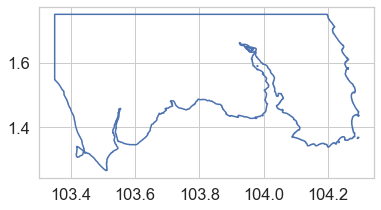

In [9]:
# Display clipped boundary
malaysia_boundary_clipped.boundary.plot()

## Data Processing

### NO2 Percent Change

In [10]:
# Calculate difference
no2_difference = no2_mean_20200101_20200630 - no2_mean_20190101_20190630

In [11]:
# Calculate the percent change
percent_change = np.divide(
    (no2_mean_20200101_20200630 - no2_mean_20190101_20190630), 
    no2_mean_20190101_20190630) * 100
print(f"Percent change type: {type(percent_change)}")
print(f"Percent change min: {percent_change.min()}")
print(f"Percent change max: {percent_change.max()}")

Percent change type: <class 'numpy.ndarray'>
Percent change min: -48.80146955963743
Percent change max: 24.70021534147933


### NO2 Time Series

In [12]:
# Get Level-3 files into list
level3_files = glob.glob(os.path.join(
    "03-processed-data", "raster", "singapore", "daily", "*.tif"
))

In [13]:
# Get list of timestamps and NO2 means into arrays
timestamps = []
means = []
for level3_file in level3_files:

    # Parse timestamp and create datetime object
    timestamp = os.path.basename(level3_file)[27:46].split('-')
    year, month, day = list(map(int, timestamp[:-1]))
    hour, minute, second = list(
        map(int, [timestamp[3][1:3], timestamp[3][3:5], timestamp[3][5:7]]))
    timestamps.append(pd.datetime(
        year, month, day, hour, minute, second, tzinfo=pytz.utc))

    # Calculate NO2 mean
    with rio.open(level3_file) as file:
        means.append(np.nanmean(file.read(1)))

# Convert lists to arrays (for plotting)
timestamps_arr, means_arr = np.array(timestamps), np.array(means)

## Data Postprocessing

Need to add examination of how much of each scene consists of no data values. What percentage of pixels.

## Data Visualization

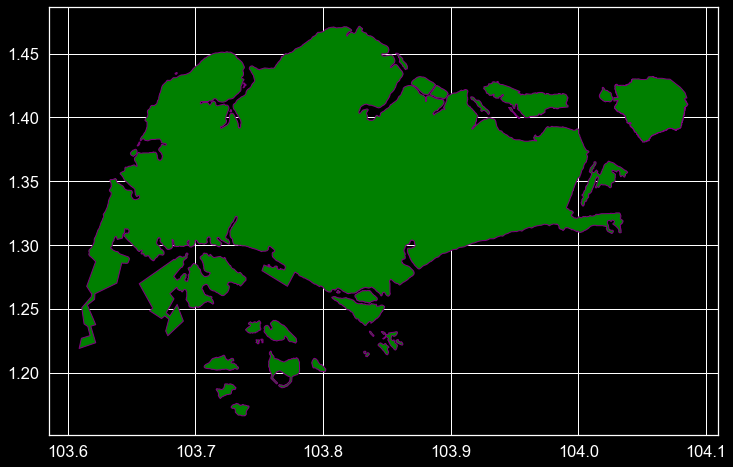

In [14]:
# Plot Singapore boundary
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(12, 12))
    singapore_boundary.boundary.plot(
        facecolor='green', edgecolor='purple', linewidth=1, ax=ax)

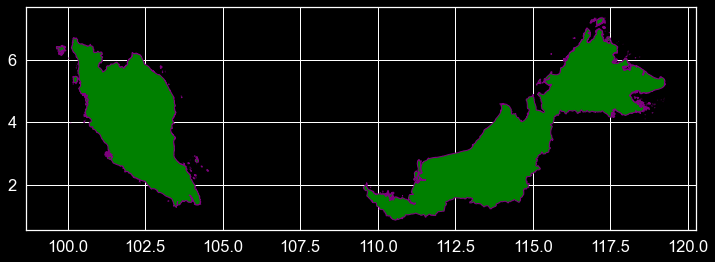

In [15]:
# Plot Malaysia boundary
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(12, 12))
    malaysia_boundary.boundary.plot(
        facecolor='green', edgecolor='purple', linewidth=1, ax=ax)

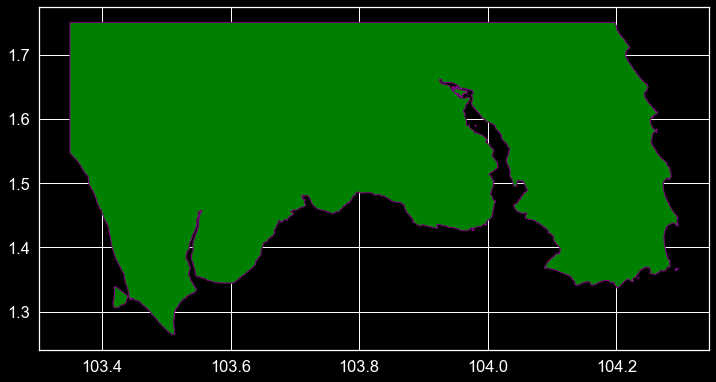

In [16]:
# Plot Malaysia clipped boundary
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(12, 12))
    malaysia_boundary_clipped.boundary.plot(
        facecolor='green', edgecolor='purple', linewidth=1, ax=ax)

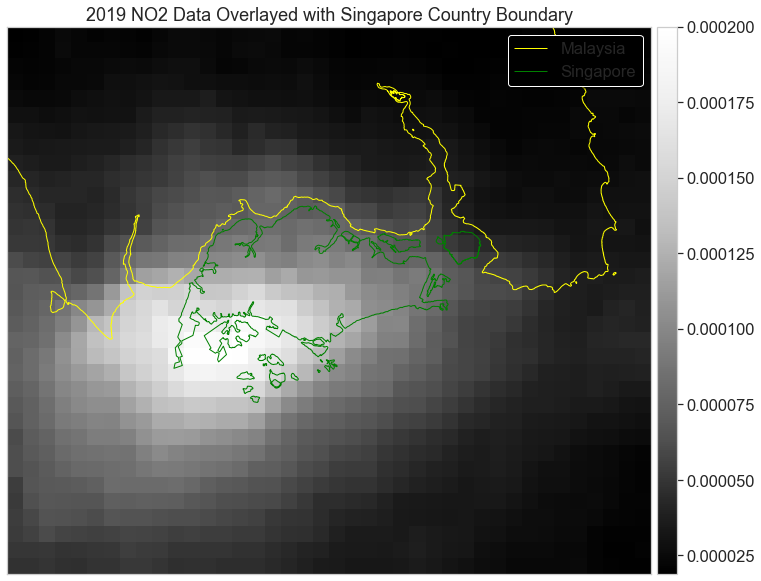

In [17]:
# Plot Singapore boundary over 2019 NO2 data
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_bands(
    no2_mean_20190101_20190630,
    ax=ax,
    title="2019 NO2 Data Overlayed with Singapore Country Boundary",
    extent=singapore_extent)

malaysia_boundary_clipped.boundary.plot(
    edgecolor='yellow', 
    linewidth=1, 
    ax=ax, 
    alpha=1,
    label='Malaysia')

singapore_boundary.boundary.plot(
    edgecolor='green', 
    linewidth=1, 
    ax=ax, 
    alpha=1,
    label='Singapore')

ax.legend(
    shadow=True, 
    facecolor='black',
    edgecolor='white',
)

plt.show()

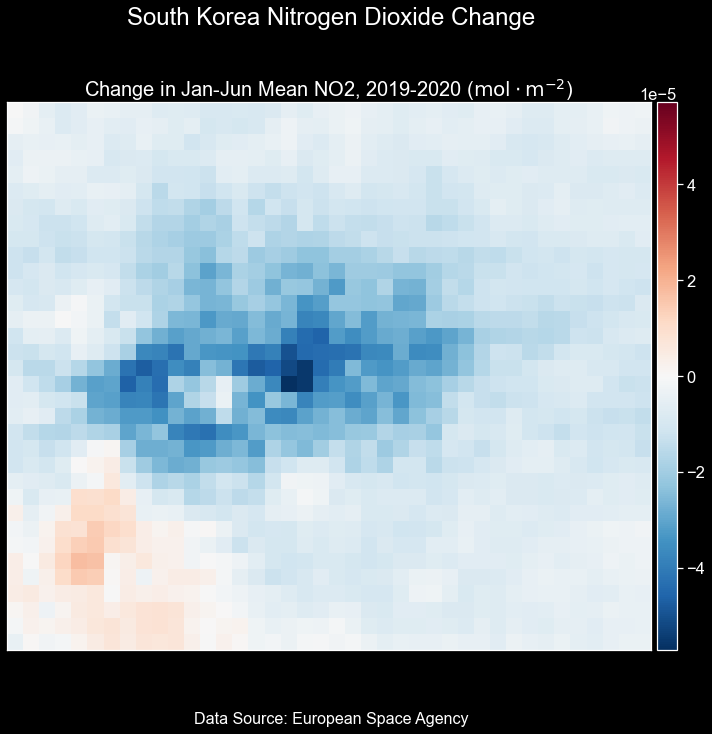

In [18]:
# Plot the 2019 to 2020 change
fig, ax = stl.plot_change(
    no2_mean_20190101_20190630, 
    no2_mean_20200101_20200630, 
    title='Change in Jan-Jun Mean NO2, 2019-2020')
plt.show()

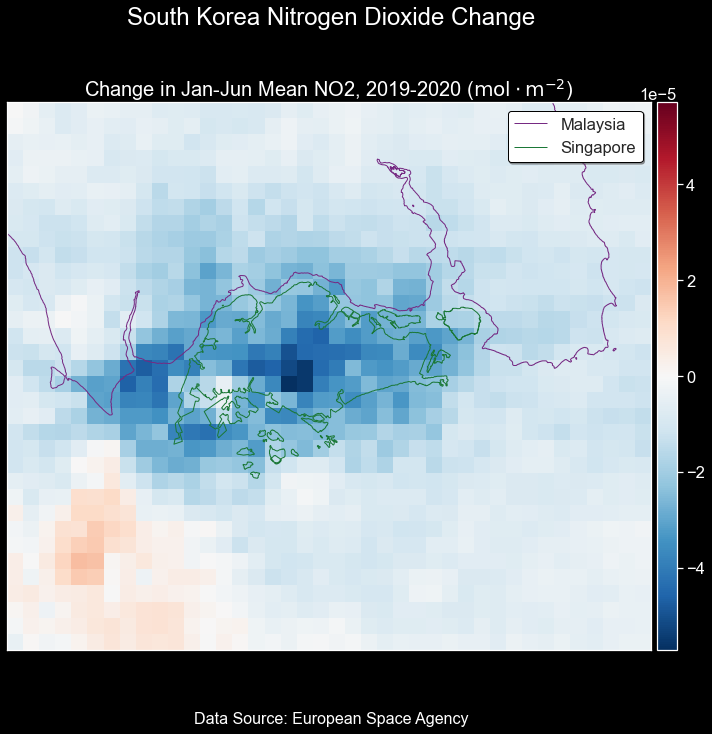

In [19]:
# Plot the 2019 to 2020 change, with boundary
fig, ax = stl.plot_change_with_boundary(
    no2_mean_20190101_20190630,
    no2_mean_20200101_20200630,
    extent_file=no2_2019_tif_path, 
    title='Change in Jan-Jun Mean NO2, 2019-2020')

malaysia_boundary_clipped.boundary.plot(
    edgecolor='#762a83',
    linewidth=1, 
    ax=ax, 
    alpha=1,
    label='Malaysia')

singapore_boundary.boundary.plot(
    edgecolor='#1b7837',
    linewidth=1,
    ax=ax, 
    alpha=1,
    label='Singapore')

ax.legend(
    shadow=True, 
    edgecolor='black',
)

plt.show()

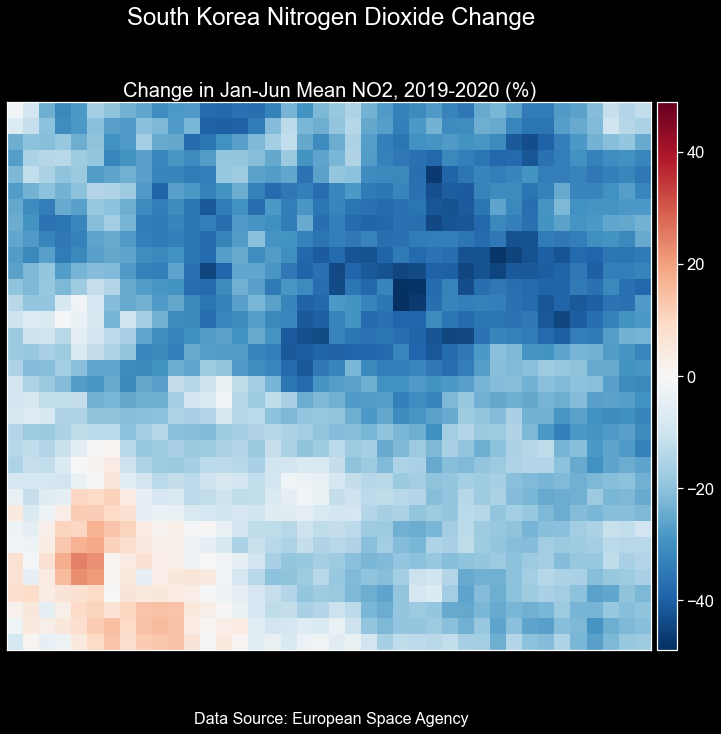

In [20]:
# Plot percent change
fig = stl.plot_percent_change(
    percent_change, title='Change in Jan-Jun Mean NO2, 2019-2020')
plt.show()

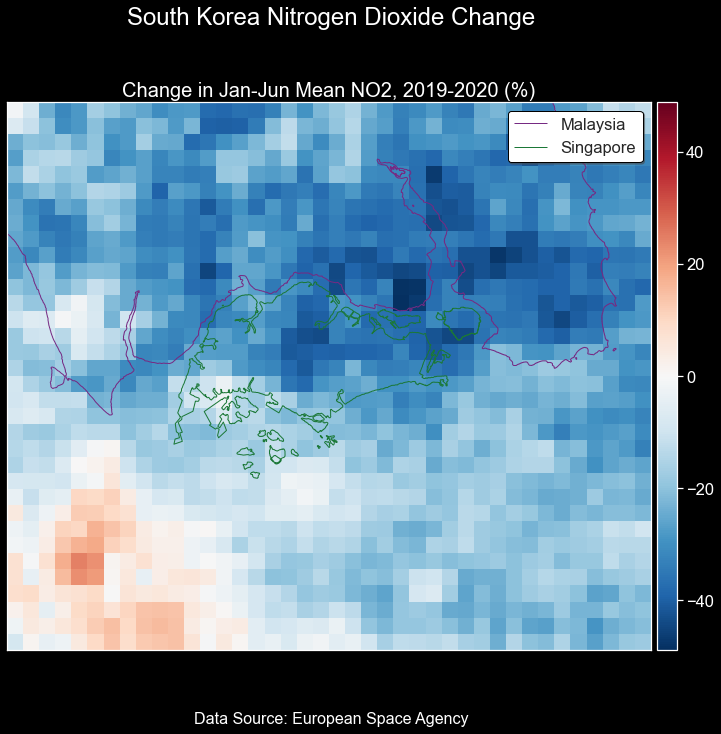

In [21]:
# Plot percent change, with boundary
fig, ax = stl.plot_percent_change_with_boundary(
    percent_change, extent_file=no2_2019_tif_path, 
    title='Change in Jan-Jun Mean NO2, 2019-2020')

malaysia_boundary_clipped.boundary.plot(
    edgecolor='#762a83',
    linewidth=1, 
    ax=ax, 
    alpha=1,
    label='Malaysia')

singapore_boundary.boundary.plot(
    edgecolor='#1b7837',
    linewidth=1,
    ax=ax, 
    alpha=1,
    label='Singapore')

ax.legend(
    shadow=True, 
    edgecolor='black'
)

plt.show()

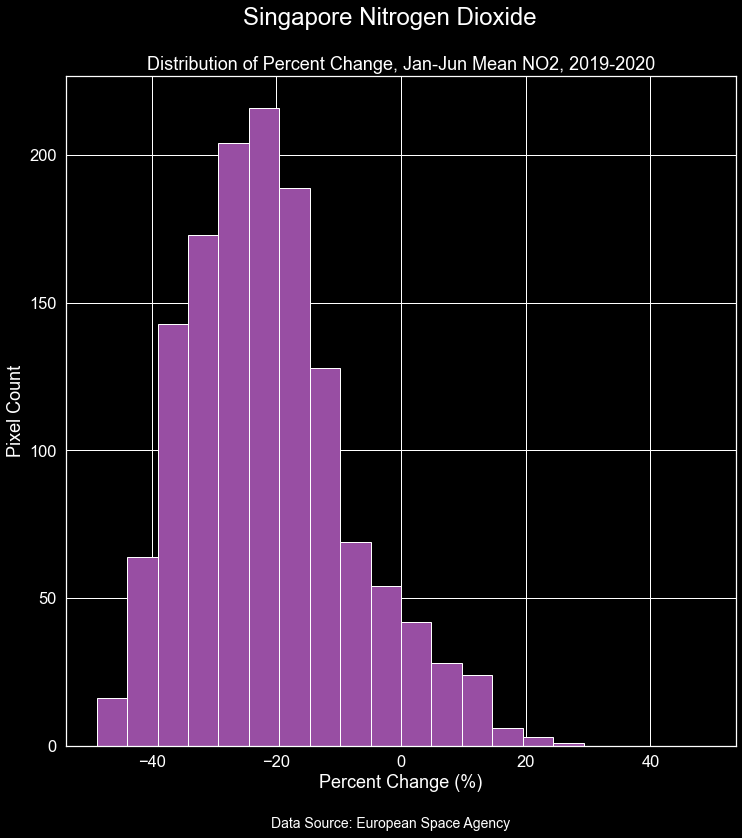

In [22]:
# Plot histogram of percent change
fig = stl.plot_histogram(percent_change, location="Singapore")
plt.show()

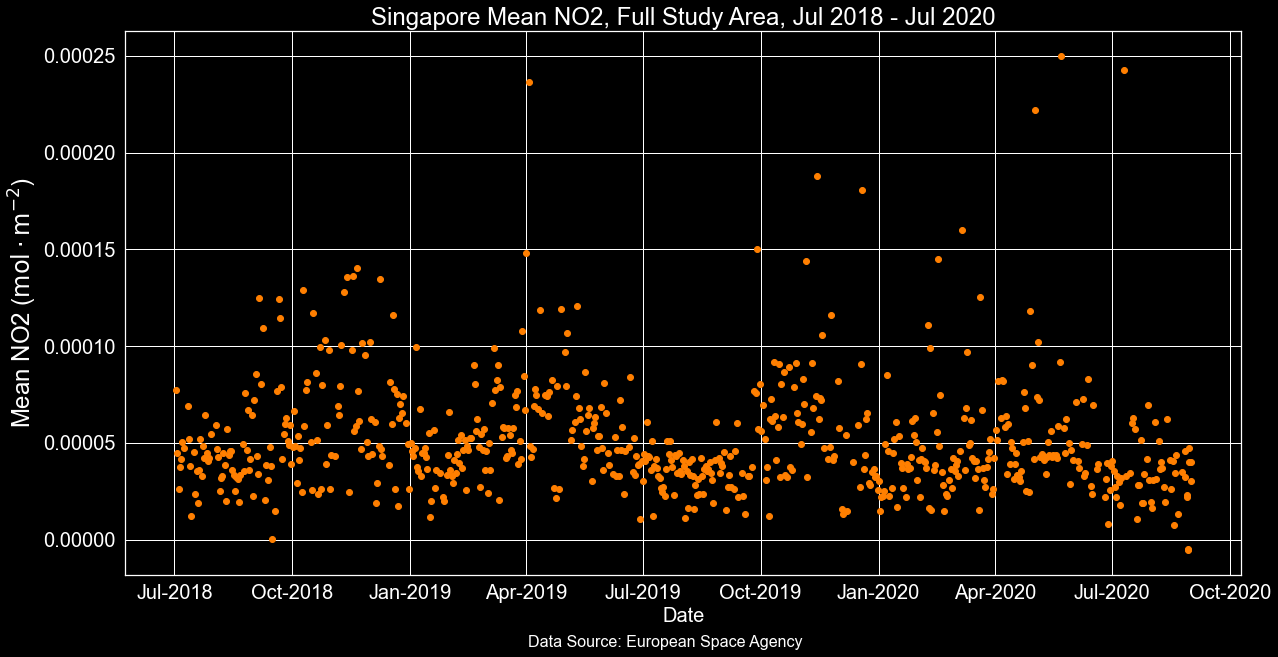

In [23]:
# Plot full study area time series mean
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(timestamps_arr, means_arr, facecolor='#ff7f00')
    ax.set_title('Singapore Mean NO2, Full Study Area, Jul 2018 - Jul 2020', size=24)
    ax.set_xlabel('Date', size=20)
    ax.set_ylabel('Mean NO2 ($\mathrm{mol \cdot m^{-2}}$)', size=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    fig.text(0.5, 0.025, "Data Source: European Space Agency", ha='center', fontsize=16)

plt.show()

## Data Export

### Non-Georeferenced

Saved plot: singapore-no2-mean-change-jan-jun-2019-2020.png


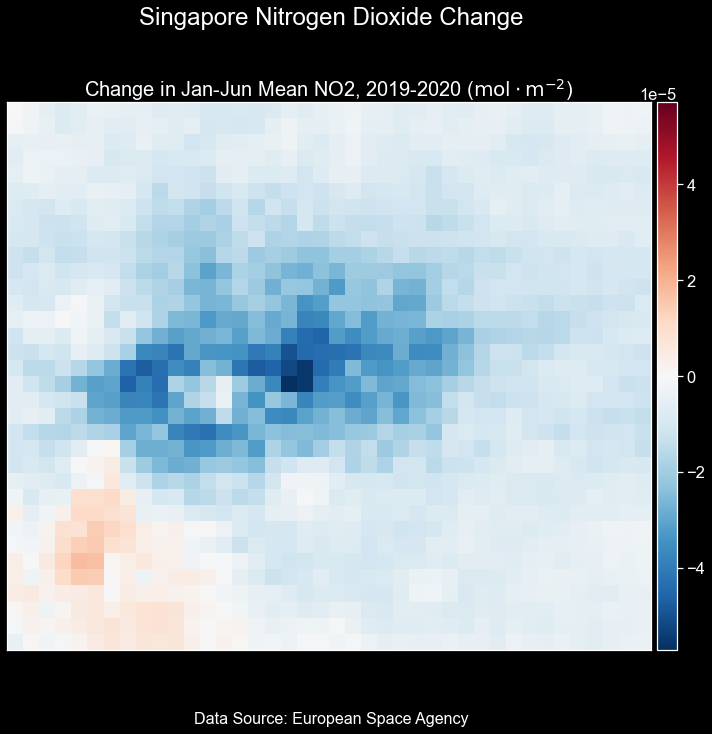

In [24]:
# Export 2019 to 2020 change
fig = stl.plot_change(
    no2_mean_20190101_20190630,
    no2_mean_20200101_20200630,
    location="Singapore",
    title='Change in Jan-Jun Mean NO2, 2019-2020')

rd.save_figure(os.path.join(
    "04-graphics-outputs", "spatial-plots", "singapore", 
    "singapore-no2-mean-change-jan-jun-2019-2020.png"
))

Saved plot: singapore-no2-mean-change-jan-jun-2019-2020-with-boundary.png


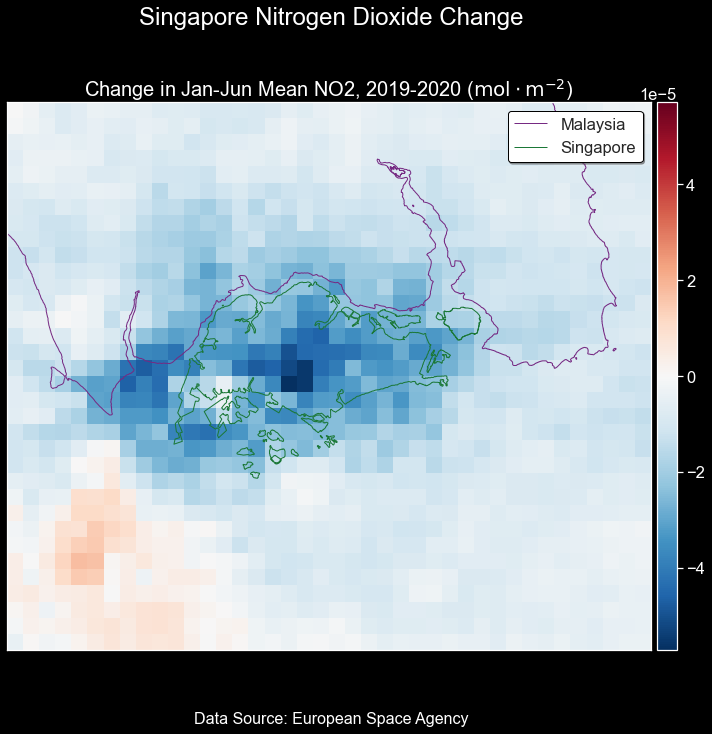

In [25]:
# Plot the change only, with boundary, and export
fig, ax = stl.plot_change_with_boundary(
    no2_mean_20190101_20190630, 
    no2_mean_20200101_20200630, 
    extent_file=no2_2019_tif_path, 
    location='Singapore',
    title='Change in Jan-Jun Mean NO2, 2019-2020')

malaysia_boundary_clipped.boundary.plot(
    edgecolor='#762a83',
    linewidth=1, 
    ax=ax, 
    alpha=1,
    label='Malaysia')

singapore_boundary.boundary.plot(
    edgecolor='#1b7837',
    linewidth=1,
    ax=ax, 
    alpha=1,
    label='Singapore')

ax.legend(
    shadow=True, 
    edgecolor='black',
)

rd.save_figure(os.path.join(
    "04-graphics-outputs", "spatial-plots", "singapore", 
    "singapore-no2-mean-change-jan-jun-2019-2020-with-boundary.png"
))

Saved plot: singapore-no2-mean-change-percent-jan-jun-2019-2020.png


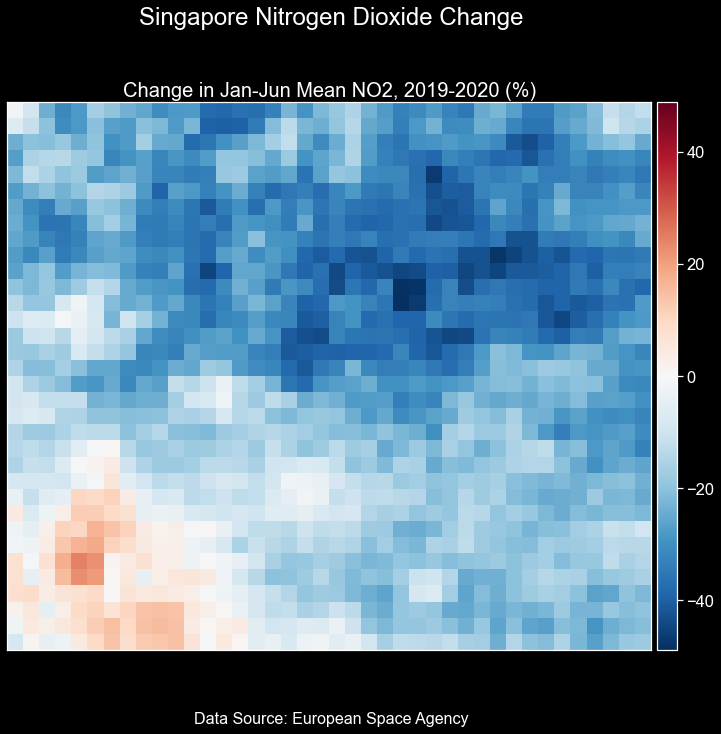

In [26]:
# Plot and export percent change
fig = stl.plot_percent_change(
    percent_change, 
    location="Singapore",
    title='Change in Jan-Jun Mean NO2, 2019-2020')

rd.save_figure(os.path.join(
    "04-graphics-outputs", "spatial-plots", "singapore",
    "singapore-no2-mean-change-percent-jan-jun-2019-2020.png"
))

Saved plot: singapore-no2-mean-change-percent-jan-jun-2019-2020-with-boundary.png


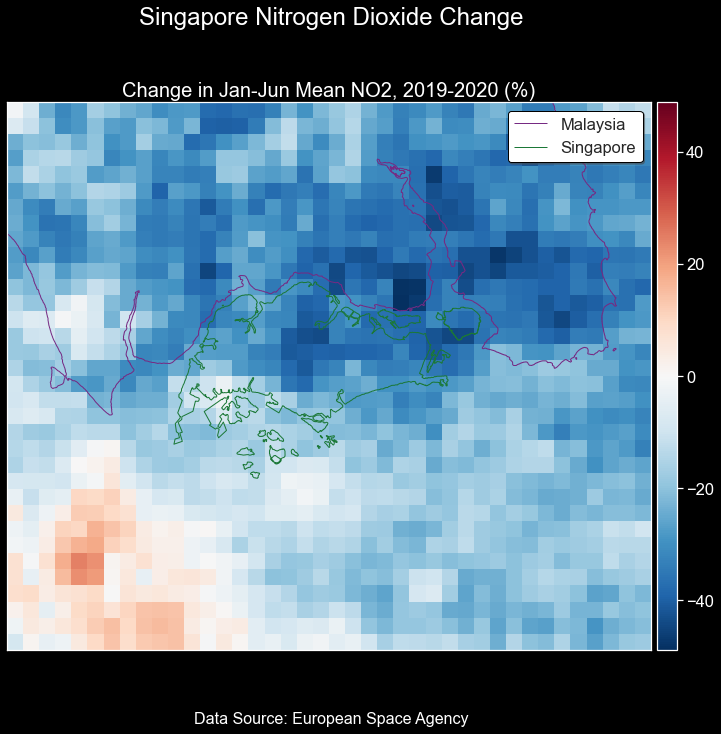

In [27]:
# Plot percent change, with boundary
fig, ax = stl.plot_percent_change_with_boundary(
    percent_change, extent_file=no2_2019_tif_path, 
    location="Singapore",
    title='Change in Jan-Jun Mean NO2, 2019-2020')

malaysia_boundary_clipped.boundary.plot(
    edgecolor='#762a83',
    linewidth=1, 
    ax=ax, 
    alpha=1,
    label='Malaysia')

singapore_boundary.boundary.plot(
    edgecolor='#1b7837',
    linewidth=1,
    ax=ax, 
    alpha=1,
    label='Singapore')

ax.legend(
    shadow=True, 
    edgecolor='black',
)

rd.save_figure(os.path.join(
    "04-graphics-outputs", "spatial-plots", "singapore", 
    "singapore-no2-mean-change-percent-jan-jun-2019-2020-with-boundary.png"
))

Saved plot: singapore-no2-mean-change-percent-histogram-jan-jun-2019-2020.png


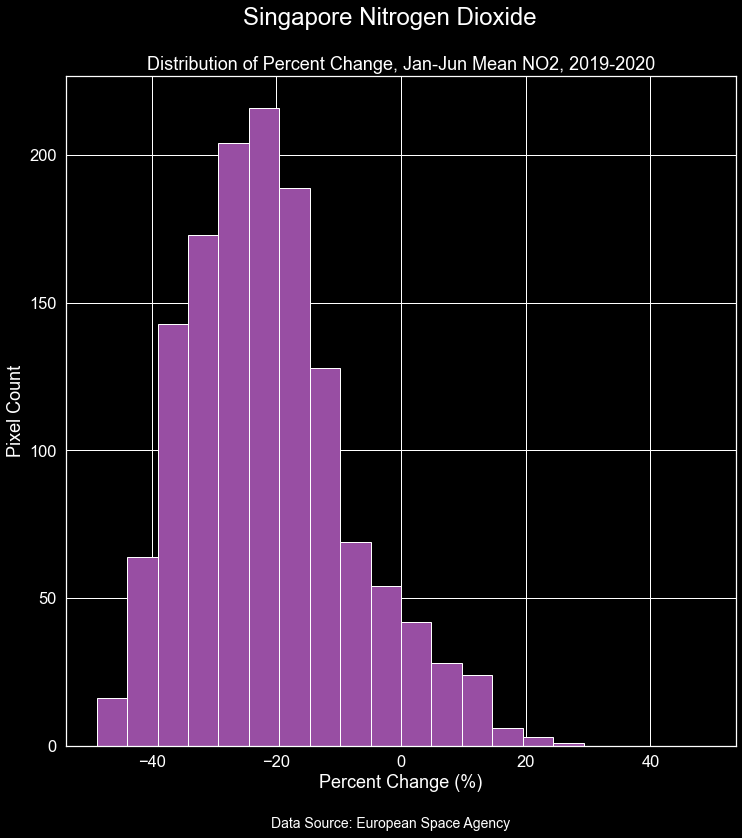

In [28]:
# Plot and export histogram of percent change
fig = stl.plot_histogram(percent_change, location="Singapore")

rd.save_figure(os.path.join(
    "04-graphics-outputs", "histograms", "singapore", 
    "singapore-no2-mean-change-percent-histogram-jan-jun-2019-2020.png"
))

Saved plot: singapore-no2-mean-full-study-area-jul-2018-2020.png


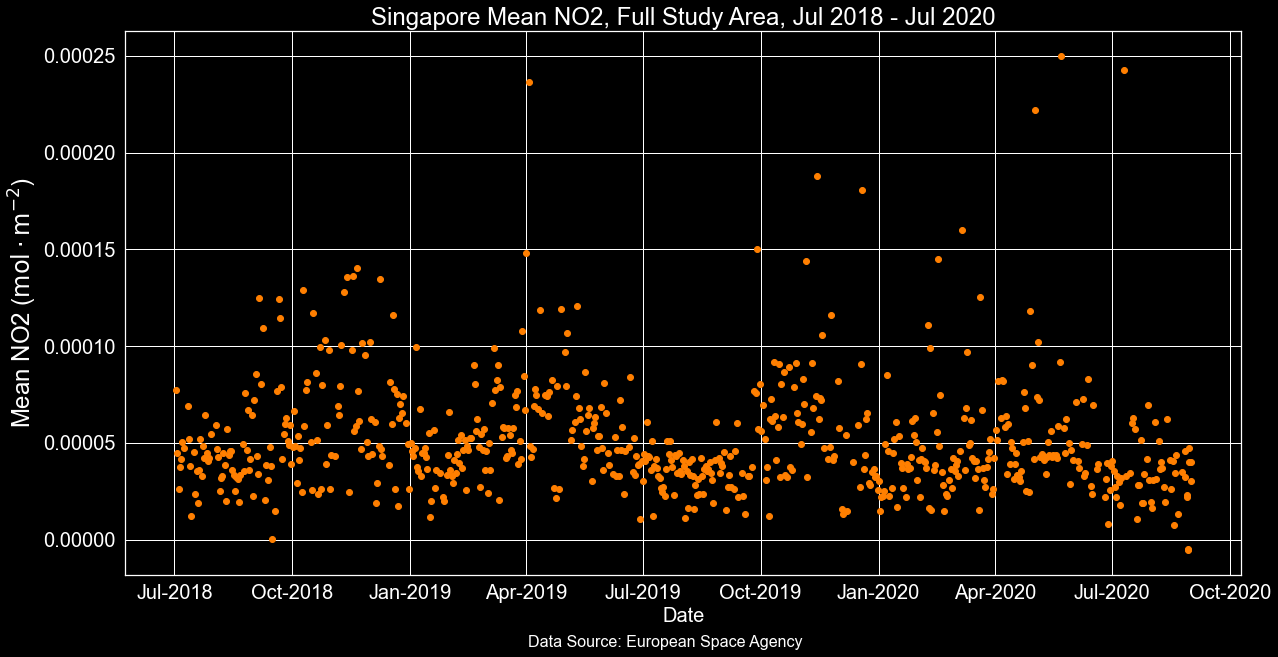

In [29]:
# Plot and export full study area time series mean
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(timestamps_arr, means_arr, facecolor='#ff7f00')
    ax.set_title('Singapore Mean NO2, Full Study Area, Jul 2018 - Jul 2020', size=24)
    ax.set_xlabel('Date', size=20)
    ax.set_ylabel('Mean NO2 ($\mathrm{mol \cdot m^{-2}}$)', size=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    fig.text(0.5, 0.025, "Data Source: European Space Agency", ha='center', fontsize=16)

rd.save_figure(os.path.join(
    "04-graphics-outputs", "time-series", "Singapore", 
    "singapore-no2-mean-full-study-area-jul-2018-2020.png"
))

### Georeferenced

In [30]:
# Extract metadata from GeoTiff
singapore_metadata = stl.extract_geotiff_metadata(no2_2020_tif_path)
singapore_metadata

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': nan,
 'width': 40,
 'height': 34,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.025, 0.0, 103.35000000000001,
        0.0, -0.025, 1.75)}

In [31]:
# Export NO2 change (magnitude and percent)
export_files = [
    (
        no2_difference,
        os.path.join(
            "03-processed-data", "raster", "singapore", "change",
            "singapore-no2-mean-change-jan-jun-2019-2020.tif")
    ),
    (
        percent_change,
        os.path.join(
            "03-processed-data", "raster", "singapore", "change",
            "singapore-no2-mean-change-percent-jan-jun-2019-2020.tif")
    )
]

for (array, outpath) in export_files:
    rd.export_array(array, outpath, singapore_metadata)

Exported: singapore-no2-mean-change-jan-jun-2019-2020.tif
Exported: singapore-no2-mean-change-percent-jan-jun-2019-2020.tif
